# Project 4, APS1070 Fall 2020
#### **Linear Regression -  20 points**
**Deadline: Nov 29, 23:59**

**Academic Integrity**

This project is individual - it is to be completed on your own. If you have questions, please post your query in the APS1070 Piazza Q&A forums (the answer might be useful to others!).

Do not share your code with others, or post your work online. Do not submit code that you have not written yourself. Students suspected of plagiarism on a project, midterm or exam will be referred to the department for formal discipline for breaches of the Student Code of Conduct.

Please fill out the following:


*   Your **name**: Zian Zhuang
*   Your **student number**: 1002449870



## Part 1 - Getting Started [1 mark]

In Parts 1- 6 of this project, we are designing a controller to manage the ailerons of an F16 Aircraft! 

![Ailerons](https://raw.githubusercontent.com/aps1070-2019/datasets/master/img/airplane.gif) [Ref](https://www.grc.nasa.gov/www/k-12/BGA/Mike/airplane_parts_act.htm) 


The features describe the airplane's status, and our goal is to predict the `Goal` column, which is a command that our controller should issue. We will make our predictions by implementing linear regression without regularization.

In [1]:
import pandas as pd
df=pd.read_csv("https://raw.githubusercontent.com/aps1070-2019/datasets/master/F16L.csv" , skipinitialspace=True)

1. Print the dataframe.
2. Prepare your dataset as follows: **[1]**
*   Split the dataset into training and validation sets (80% training, 20% validation). When splitting, set `random_state=1`.
*   Standardize the data using StandardScaler from sklearn.
*   Insert a first column of 1s in both the training and validation data sets.


In [2]:
# create dataframe
airplane_raw = pd.DataFrame(df.values, index=df.index, columns=df.columns)
# print dataframe
print(airplane_raw)

       inputs ClimbRate   Sgz     P     Q  ...  DiffSeTime14  Alpha     Se    Goal
0                 -17.0  -6.0 -0.03  0.14  ...           0.0    0.6  0.021 -0.0008
1                -791.0  15.0 -0.28 -0.34  ...           0.0    0.4  0.013 -0.0009
2                 -46.0  48.0 -0.42  0.07  ...           0.0    0.5  0.019 -0.0005
3                 496.0  -5.0 -0.21 -0.04  ...           0.0    0.5  0.017 -0.0005
4                -124.0  16.0 -0.02  0.05  ...           0.0    0.5  0.018 -0.0006
...                 ...   ...   ...   ...  ...           ...    ...    ...     ...
13745             -53.0 -13.0 -0.07  0.02  ...           0.0    0.5  0.019 -0.0007
13746               1.0   4.0 -0.11 -0.07  ...           0.0    0.5  0.016 -0.0004
13747             425.0 -14.0  0.40  0.07  ...           0.0    0.9  0.032 -0.0015
13748             102.0 -10.0 -0.19  0.08  ...           0.0    1.4  0.051 -0.0015
13749            -165.0  52.0  0.08  0.42  ...           0.0    0.9  0.034 -0.0018

[13

In [3]:
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

feature_raw = airplane_raw.drop('Goal', axis = 1)
target_raw = airplane_raw['Goal']

# split dataset (8:2)
X_train, X_test, t_train, t_test = train_test_split(feature_raw, target_raw, test_size=0.2, random_state=1)

# standardize dataset (only feature data)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

# insert a column of 1
X_train_1 = np.hstack((np.ones((X_train_std.shape[0],1)), X_train_std)) # training sets
X_test_1 = np.hstack((np.ones((X_test_std.shape[0],1)), X_test_std)) # validation sets

## Part 2 - Linear Regression - Direct Solution [2 marks]

Implement the direct solution to linear regression on the training set. **[1]**

Report the root-mean-square error (RMSE) for both the training and validation sets.**[1]**

In [4]:
# direct solution
from scipy.linalg import inv
W = np.dot(inv(np.dot(X_train_1.T, X_train_1)), np.dot(X_train_1.T, t_train))

# prediction
yPred_train = np.dot(X_train_1, W) # training sets
yPred_test = np.dot(X_test_1, W) # validation sets

# report RMSE
from sklearn.metrics import mean_squared_error
def rmse(yPred, y):
    return np.sqrt(mean_squared_error(yPred, y))

print('RMSE for training sets: ', rmse(yPred_train, t_train))
print('RMSE for validation sets: ', rmse(yPred_test, t_test))

RMSE for training sets:  0.0001983241902503662
RMSE for validation sets:  0.0001874084898605524


## Part 3 - Full Batch Gradient Descent [2 marks]

We will now implement a full batch gradient descent algorithm and record the training time for our model.

1. Implement gradient descent for linear regression using a fixed learning rate of $\alpha= 1e-2$, and by iterating until your model's validation RMSE converges. Here we will consider it converged once validation RMSE is within 0.1% of the Direct Solution RMSE (i.e., $RMSE_{GD} <= RMSE_{Direct Solution}*1.001$). We call this value **Convergence threshold ($CT = RMSE_{Direct Solution}*1.001$)** and will use this value in the next parts too.

  *  Record the training time (from the first iteration until convergence) using the `time.time()` function. Be sure to compute the gradients yourself! Take a look at the code provided in the tutorial.**[0.5]**

  * Plot the Training RMSE and the Validation RMSE vs epoch on the same figure. Epoch is the number of passes on the full training set - for full batch gradient descent, it's the same as the # of gradient updates (iterations). **[0.5]**

2. Comment on overfitting/underfitting - is running the algorithm too long a concern here? **[1]**

The model is not overfitting because it is trained on full batch, which picks up general trend (gradient) of the whole dataset and isn't emphasized on local noise of the data. But, the computational time of this method is long because it needs to compute gradient based on the whole dataset every iteration.

--- Total Training Time: 2.9003543853759766 (s) ---


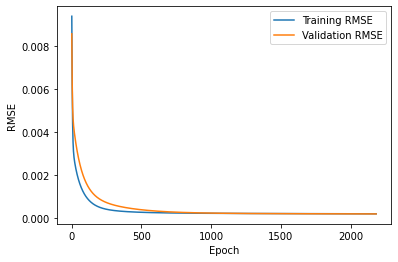

In [5]:
import matplotlib.pyplot as plt
import random

LR = 0.01 # fixed learning rate
CT = rmse(yPred_test, t_test)*1.001 # convergence threshold

# initialize weights
np.random.seed(1000) # for comparison consistency, need to remove if implementing
w_full = (np.random.random(X_train_1.shape[1])).reshape(1,-1)/1000 # divide 1000 to fasten convergence
#w_full = (np.random.random(X_train_1.shape[1])).reshape(1,-1)

rmse_array_train = []
rmse_array_test = []
RMSE_GD = CT + 1 # initialize RMSE_GD values
epoch_count = 0 # initialize epoch counts

import time
start_time = time.time()

while RMSE_GD > CT:
  y_train = np.dot(X_train_1, w_full.T).reshape(-1,1)
  rmse_array_train.append(rmse(y_train, t_train))
  gradient = (1/len(y_train) * np.dot(X_train_1.T, y_train-np.array(t_train).reshape(-1,1))).reshape(1,-1)
  w_full = w_full - LR * gradient
  epoch_count += 1

  # calculate validation RMSE
  y_test = np.dot(X_test_1, w_full.T).reshape(-1,1)
  RMSE_GD = rmse(y_test, t_test)
  rmse_array_test.append(RMSE_GD)

print("--- Total Training Time: %s (s) ---" % (time.time() - start_time))

epoch = np.linspace(1, epoch_count, epoch_count)
plt.plot(epoch, rmse_array_train, label = 'Training RMSE')
plt.plot(epoch, rmse_array_test, label = 'Validation RMSE')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()

## Part 4 - Mini-batch and Stochastic Gradient Descent [4 marks]

Write a function that performs mini-batch gradient descent until the convergence threshold (CT) is reached.**[1]** The inputs of that function are 
  * Training Data
  * Validation Data
  * Batch size
  * Learning Rate
  * Convergence Threshold (CT)
  * Maximum Iterations = 20000

Your function will return the following arrays: 
 * The final weights after training.
 * The training RMSE at each epoch (the number of epochs is the number of passes on the full data set).
 * The validation RMSE at each epoch.
 * An array that has the elapsed time from the start of the training process to the end of each epoch (e.g., if each epoch takes exactly 2 seconds the array would look like: [2 4 6 8 ...]).
 * For certain batchsizes GD might not converge to a solution. For that reason we have a parameter "Maximum iterations" where we limit the total number of iterations that this function can perform. 

In [6]:
import math
def mini_batch_gradient_descent (X_train, t_train, X_test, t_test, batch_size = 1, lr = 0.01, CT = CT, max_it = 20000):
  # initialize weights
  np.random.seed(1000) # for comparison consistency, need to remove if implementing
  w = (np.random.random(X_train.shape[1])).reshape(1,-1)/1000 # divide 1000 to fasten convergence
  #w = (np.random.random(X_train.shape[1])).reshape(1,-1)

  rmse_array_train = []
  rmse_array_test = []
  time_elapsed = []
  start_time = time.time()

  for epoch in range(max_it):
    for i in range(0, len(X_train), batch_size):
      X_i = X_train[i:i + batch_size]
      t_i = t_train[i:i + batch_size]
      y_i = np.dot(X_i, w.T).reshape(-1,1)
      gradient = (1/len(y_i) * np.dot(X_i.T, y_i-np.array(t_i).reshape(-1,1))).reshape(1,-1)
      w = w - lr * gradient

    # compute training RMSE
    y_train_epoch = np.dot(X_train, w.T).reshape(-1,1)
    rmse_array_train.append(rmse(y_train_epoch, t_train))
    # compute validation RMSE
    y_test_epoch = np.dot(X_test, w.T).reshape(-1,1)
    RMSE_GD = rmse(y_test_epoch, t_test)
    rmse_array_test.append(RMSE_GD)
    # compute time
    time_elapsed.append(time.time() - start_time)

    if RMSE_GD <= CT: # convergence criteria
      convergence = True
      break;
    elif epoch+1 == max_it or RMSE_GD == math.inf: # divergence/not able to converge criteria
      convergence = False
      break;

  return w, rmse_array_train, rmse_array_test, time_elapsed, convergence

Let's now use the function to investigate the effect of batch size on convergence. When the batch size is 1, we call that stochastic gradient descent. When the batch size equals the # of training data, it is full-batch (ie all data points are used at every iteration). Anywhere in between is mini-batch (we use some of the data).
  * Sweep different values for the mini-batch size (at least 10 values, including 1 -- Stochastic GD), each time using a learning rate of $\alpha= 1e-2$. **Hint: Try batch sizes that are powers of two (e.g., 2,4,8,16,32,...).** These batchsizes fit better on the hardware and may achieve higher performance.  **[0.5]**
  * Plot training and validation RMSE vs. **epoch** for all the batchsizes in a figure. The X-axis is Epoch # and the Y-axis is RMSE. **[0.5]**
  * Plot training and validation RMSE vs. **time** for all the batchsizes in a figure. The X-axis is Time and the Y-axis is RMSE. **[0.5]**
  * Plot Total training time (y-axis) vs. Batch size (x-axis). **[0.5]**
  * Describe your findings, including the main takeawyas from each of your plots. **[1]**

From graphs, we can see that for batch size > 64 (2^6), the gradient descent converges to a solution. Batch size of 128 shows the fastest convergent rate with the shortest computational time. With the smaller batch size, the gradient descent tends to diverge and takes a incredibe long time to compute due to it's highly effected by the noises in the dataset. It leads to overfitting. With the larger batch size, it also takes a longer time to compute because it needs to analyze a large amount of data per batch to determine the overall gradient values （eg. full batch). The ideal batch size is somewhat in between, in this case, it's 128.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_regression.py:254: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_regression.py:254: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_regression.py:254: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr

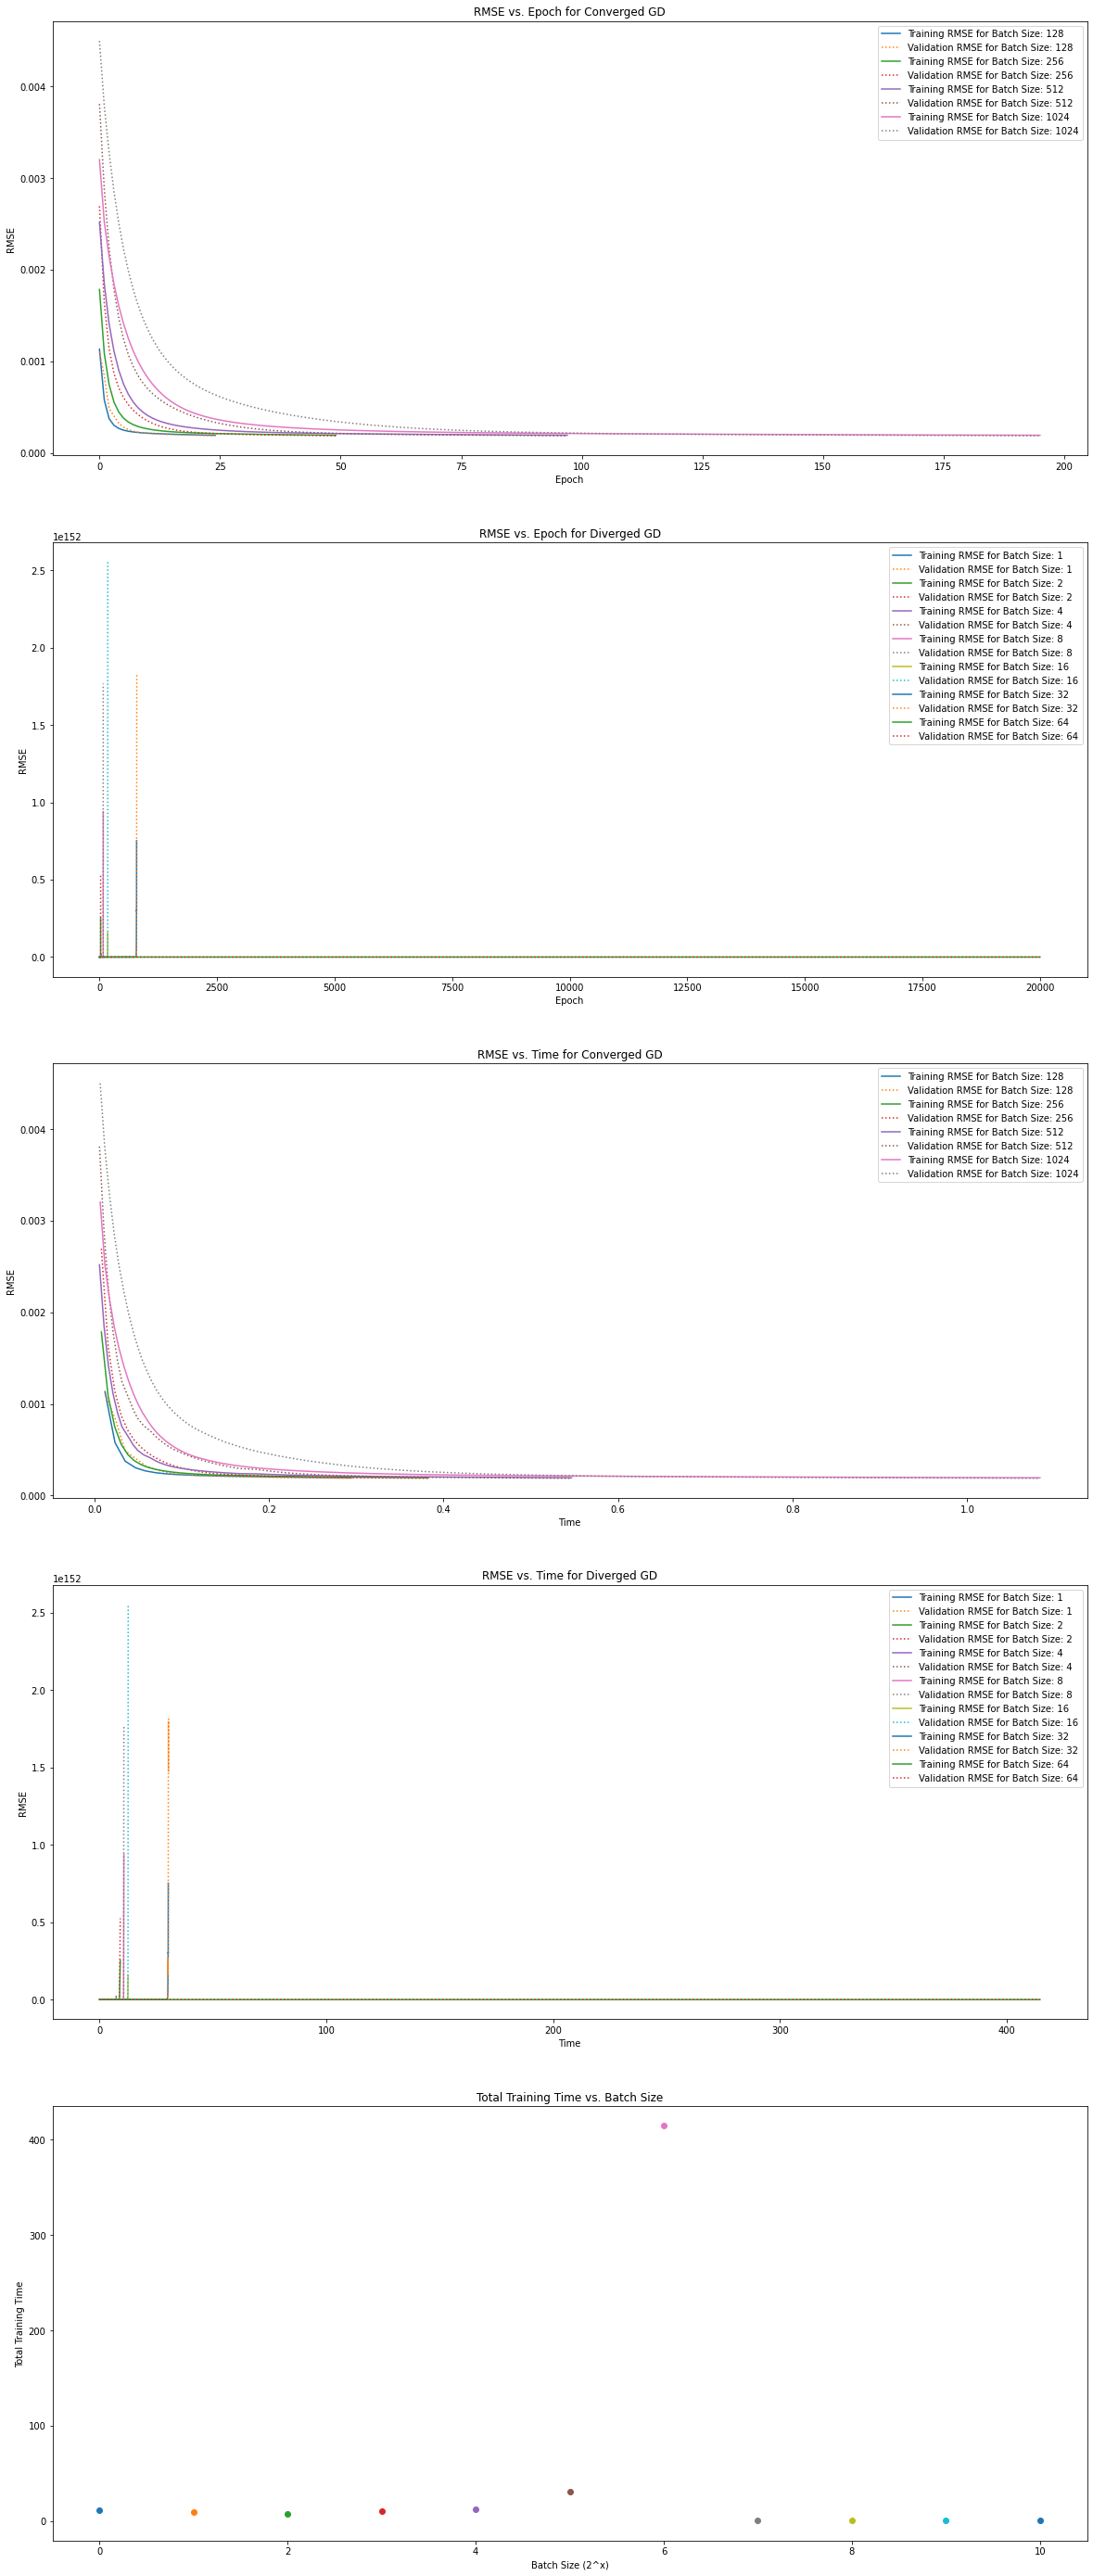

In [7]:
LR = 0.01 # fixed learning rate

fig, axs = plt.subplots(5, figsize=(20,50))
axs[0].set(xlabel = 'Epoch', ylabel = 'RMSE')
axs[0].set_title('RMSE vs. Epoch for Converged GD')
axs[1].set(xlabel = 'Epoch', ylabel = 'RMSE')
axs[1].set_title('RMSE vs. Epoch for Diverged GD')
axs[2].set(xlabel = 'Time', ylabel = 'RMSE')
axs[2].set_title('RMSE vs. Time for Converged GD')
axs[3].set(xlabel = 'Time', ylabel = 'RMSE')
axs[3].set_title('RMSE vs. Time for Diverged GD')
axs[4].set(xlabel = 'Batch Size (2^x)', ylabel = 'Total Training Time')
axs[4].set_title('Total Training Time vs. Batch Size')

for n in range (11): # try 11 different batch sizes
  size = 2**n # batch size: 1 2 4 8 16 32 ...
  weights, train_rmse, valid_rmse, time_elapsed, convergence = mini_batch_gradient_descent (X_train_1, t_train, X_test_1, t_test, batch_size = size, lr = LR, CT = CT, max_it = 20000)
  if convergence:
    axs[0].plot(train_rmse, '-', label = 'Training RMSE for Batch Size: ' + str(size))
    axs[0].plot(valid_rmse, ':', label = 'Validation RMSE for Batch Size: ' + str(size))
    axs[0].legend()
    axs[2].plot(time_elapsed, train_rmse, '-', label = 'Training RMSE for Batch Size: ' + str(size))
    axs[2].plot(time_elapsed, valid_rmse, ':', label = 'Validation RMSE for Batch Size: ' + str(size))
    axs[2].legend()
  else:
    axs[1].plot(train_rmse, '-', label = 'Training RMSE for Batch Size: ' + str(size))
    axs[1].plot(valid_rmse, ':', label = 'Validation RMSE for Batch Size: ' + str(size))
    axs[1].legend()
    axs[3].plot(time_elapsed, train_rmse, '-', label = 'Training RMSE for Batch Size: ' + str(size))
    axs[3].plot(time_elapsed, valid_rmse, ':', label = 'Validation RMSE for Batch Size: ' + str(size))
    axs[3].legend()
  axs[4].scatter(n, time_elapsed[-1])
plt.show()

## Part 5 - Gradient Descent Learning Rate [2 marks]
Use the function that you designed in Part 4 to investigate the effect of learning rate on convergence.

Select the best batch size based on the fastest convergence time and sweep the learning rate (at least 10 values) while applying Mini-batch GD. 
  1. Plot the training and validation RMSE vs **epoch** (x-axis) for all the learning rates that you tried in a figure. **[0.5]**
  2. Plot the training and validation RMSE vs **time** (x-axis) for all the learning rates that you tried in a figure. **[0.5]**
  3. Describe your findings, including the main takeawyas from each of your plots. **[1]**

From graphs, we can see that for learning rate <= 0.03125 (0.5^5), the gradient descent converges to a solution. Learning rate of 0.0078125 (0.5^7) shows the fastest convergent rate with the shortest computational time. With the faster learning rate, the gradient descent takes a incredibe long time to compute due to it's oscilating in large magnitude in order to find the convex point. It is possible to miss the minima and leads to divergence. This is a result of overfitting. With the slower learning rate, it also takes a longer time to compute because it approaches the convex point with smaller slope changes. The ideal learning rate is somewhat in between, in this cases, it's 0.0078125.


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_regression.py:254: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_regression.py:254: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_regression.py:254: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_regression.py:254: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_regression.py:254: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_regression.py:254: RuntimeWar

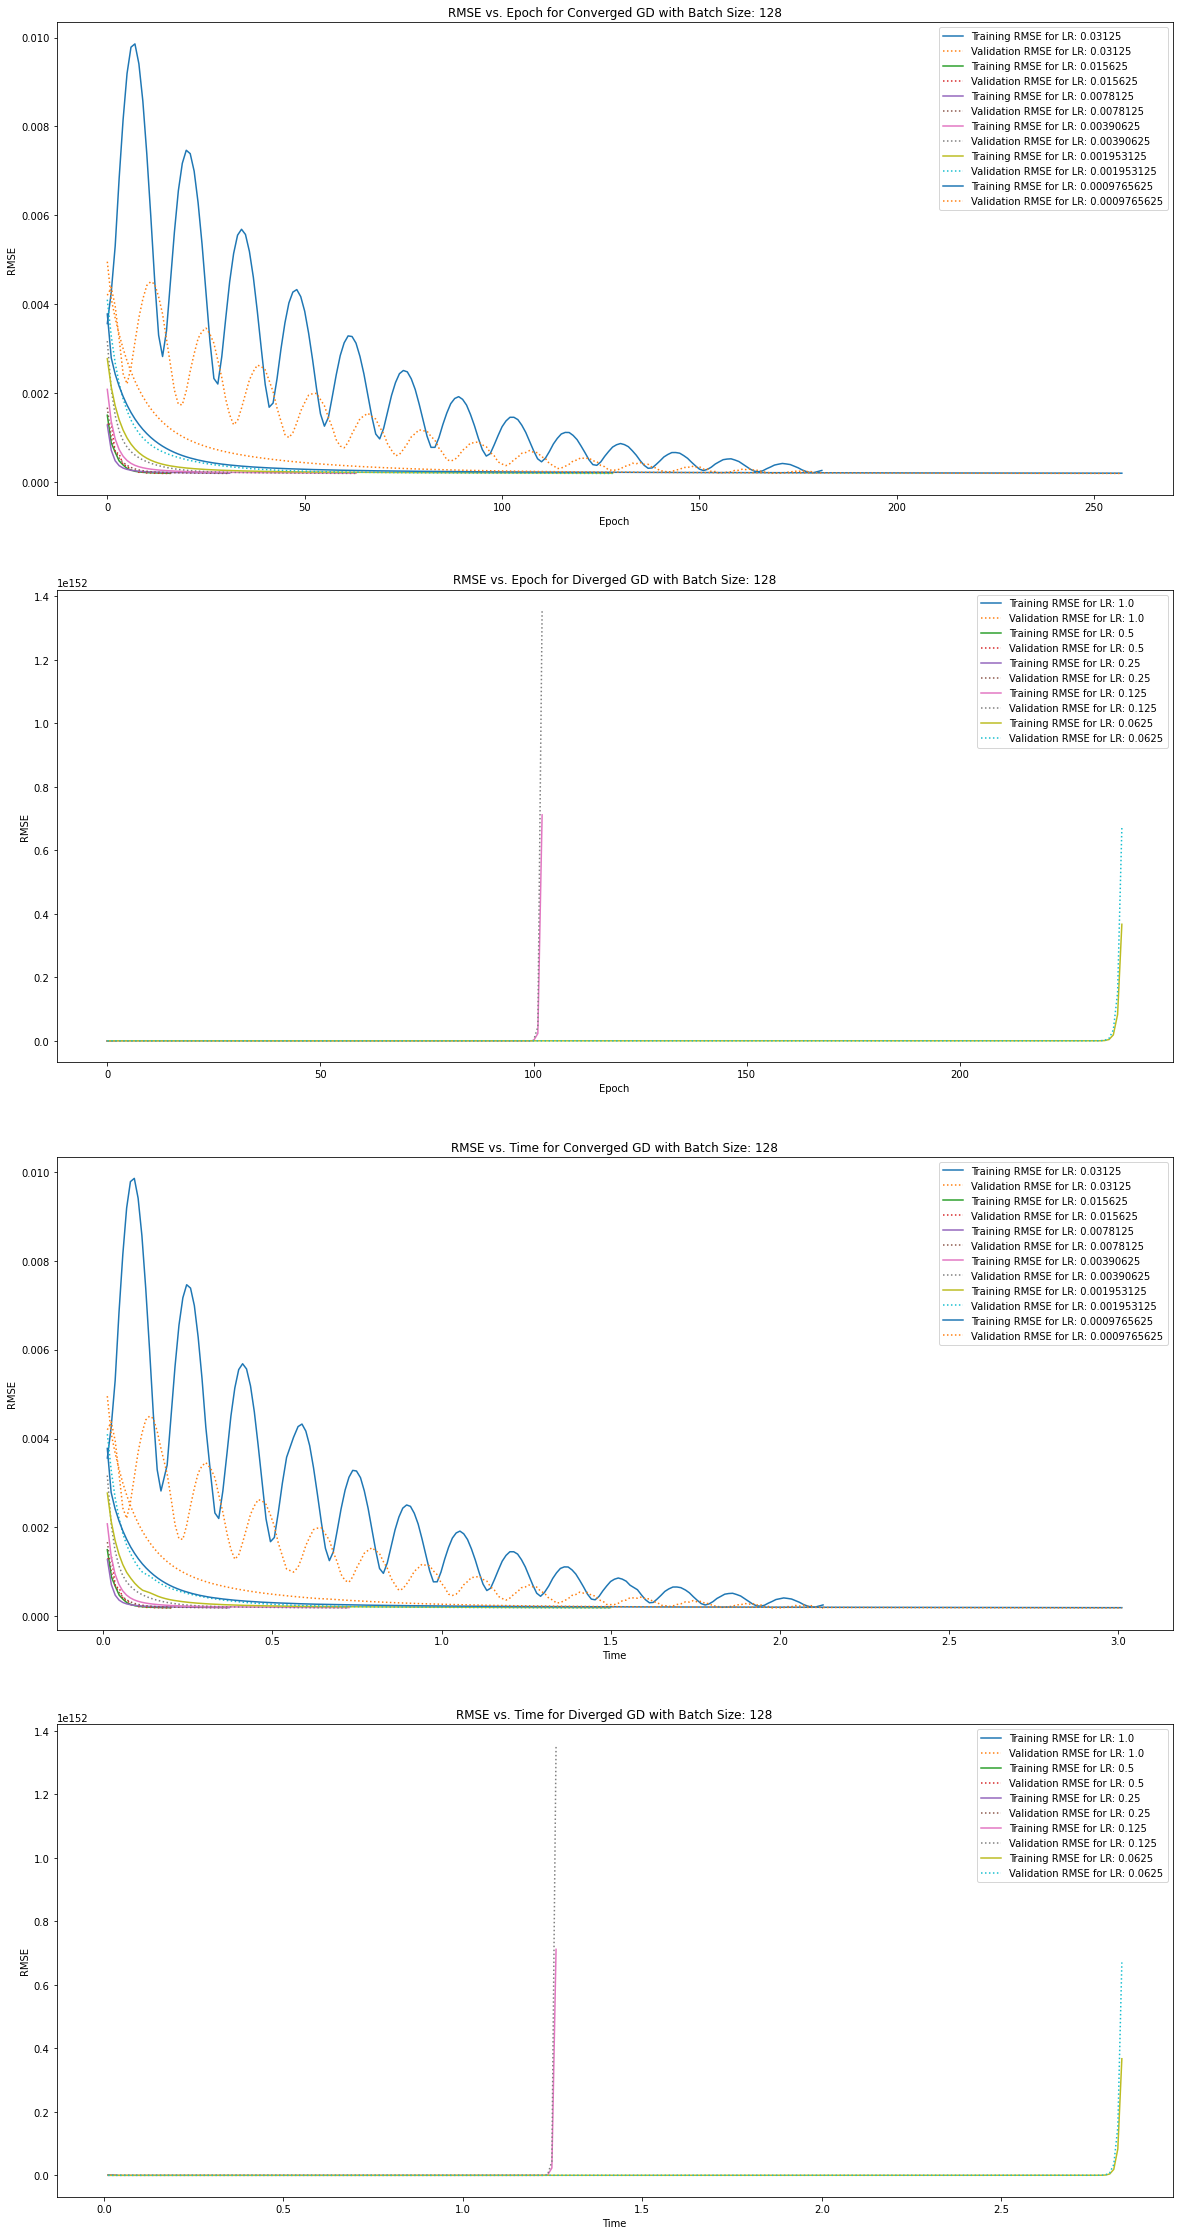

In [8]:
size = 128 # best batch size

fig, axs = plt.subplots(4, figsize=(20,40))
axs[0].set(xlabel = 'Epoch', ylabel = 'RMSE')
axs[0].set_title('RMSE vs. Epoch for Converged GD with Batch Size: ' + str(size))
axs[1].set(xlabel = 'Epoch', ylabel = 'RMSE')
axs[1].set_title('RMSE vs. Epoch for Diverged GD with Batch Size: ' + str(size))
axs[2].set(xlabel = 'Time', ylabel = 'RMSE')
axs[2].set_title('RMSE vs. Time for Converged GD with Batch Size: ' + str(size))
axs[3].set(xlabel = 'Time', ylabel = 'RMSE')
axs[3].set_title('RMSE vs. Time for Diverged GD with Batch Size: ' + str(size))

for n in range (11): # try 11 different learning rates
  LR = 0.5**n # learning rate: 1 0.5^1 0.5^2 ...
  weights, train_rmse, valid_rmse, time_elapsed, convergence = mini_batch_gradient_descent (X_train_1, t_train, X_test_1, t_test, batch_size = size, lr = LR, CT = CT, max_it = 20000)
  if convergence:
    axs[0].plot(train_rmse, '-', label = 'Training RMSE for LR: ' + str(LR))
    axs[0].plot(valid_rmse, ':', label = 'Validation RMSE for LR: ' + str(LR))
    axs[0].legend()
    axs[2].plot(time_elapsed, train_rmse, '-', label = 'Training RMSE for LR: ' + str(LR))
    axs[2].plot(time_elapsed, valid_rmse, ':', label = 'Validation RMSE for LR: ' + str(LR))
    axs[2].legend()
  else:
    axs[1].plot(train_rmse, '-', label = 'Training RMSE for LR: ' + str(LR))
    axs[1].plot(valid_rmse, ':', label = 'Validation RMSE for LR: ' + str(LR))
    axs[1].legend()
    axs[3].plot(time_elapsed, train_rmse, '-', label = 'Training RMSE for LR: ' + str(LR))
    axs[3].plot(time_elapsed, valid_rmse, ':', label = 'Validation RMSE for LR: ' + str(LR))
    axs[3].legend()
plt.show()

## Part 6 - Gradient Descent with Adaptive Learning Rate [4 marks]
Implement an adaptive learning rate scheme where you start a mini-batch gradient descent with a large learning rate and decrease the learning rate while you are getting closer to the local minima. It's up to you to come up with a way to set **when** and **how much** do you want to change the learning rate. 
Our goal is to find a method for faster convergence. 
  1. Describe **[1]** and implement **[1]** your method.

The idea is to implement an exponential decay function with respective to the epoch number based on the static learning rate. Specifically, I implemented this magic function with magic variables to achieve this goal ! So, when epoch = 0, the initial learning rate is two times faster than the best static rate found in the previous part. When epoch number increases, the adaptive learning rate decreases to the static rate, which gurantees a converged solution.

$\ AdaptiveRate = StaticRate*exp(-epoch*π) +  StaticRate $

  2. Plot the training and validation RMSE vs **epoch** for your method (adaptive learning rate), alongside your best training run from Part 5 (static learning rate). **[1]**
  3. Plot the training and validation RMSE vs **time** for your method (adaptive learning rate), alongside your best training run from Part 5 (static learning rate). **[1]**

From graphs, we can tell that this adaptive learning rate method can converge to a solution with less number of epoches than the static learning rate method found in the previous part. For each epoch it passed, the RMSE of the adaptive learning rate method is smaller than the static rate method. It also speeds up computation.

In [9]:
def mini_batch_gradient_descent_adaptive (X_train, t_train, X_test, t_test, batch_size = 128, lr = 0.0078125, CT = CT, max_it = 20000):
  # initialize weights
  np.random.seed(1000) # for comparison consistency, need to remove if implementing
  w = (np.random.random(X_train.shape[1])).reshape(1,-1)/1000 # divide 1000 to fasten convergence
  #w = (np.random.random(X_train.shape[1])).reshape(1,-1)

  rmse_array_train = []
  rmse_array_test = []
  time_elapsed = []
  start_time = time.time()

  for epoch in range(max_it):
    for i in range(0, len(X_train), batch_size):
      X_i = X_train[i:i+batch_size]
      t_i = t_train[i:i+batch_size]
      y_i = np.dot(X_i, w.T).reshape(-1,1)
      gradient = (1/len(y_i) * np.dot(X_i.T, y_i-np.array(t_i).reshape(-1,1))).reshape(1,-1)
      LR = lr*math.e**(-epoch*math.pi)+lr # update the adpative learning rate with the function described in Part 6.1
      w = w - LR * gradient

    # compute training RMSE
    y_train_epoch = np.dot(X_train, w.T).reshape(-1,1)
    rmse_array_train.append(rmse(y_train_epoch, t_train))
    # compute validation RMSE
    y_test_epoch = np.dot(X_test, w.T).reshape(-1,1)
    RMSE_GD = rmse(y_test_epoch, t_test)
    rmse_array_test.append(RMSE_GD)
    # compute time
    time_elapsed.append(time.time() - start_time)

    if RMSE_GD <= CT:
      convergence = True
      break;
    elif epoch+1 == max_it or RMSE_GD == math.inf:
      convergence = False
      break;

  return w, rmse_array_train, rmse_array_test, time_elapsed, convergence

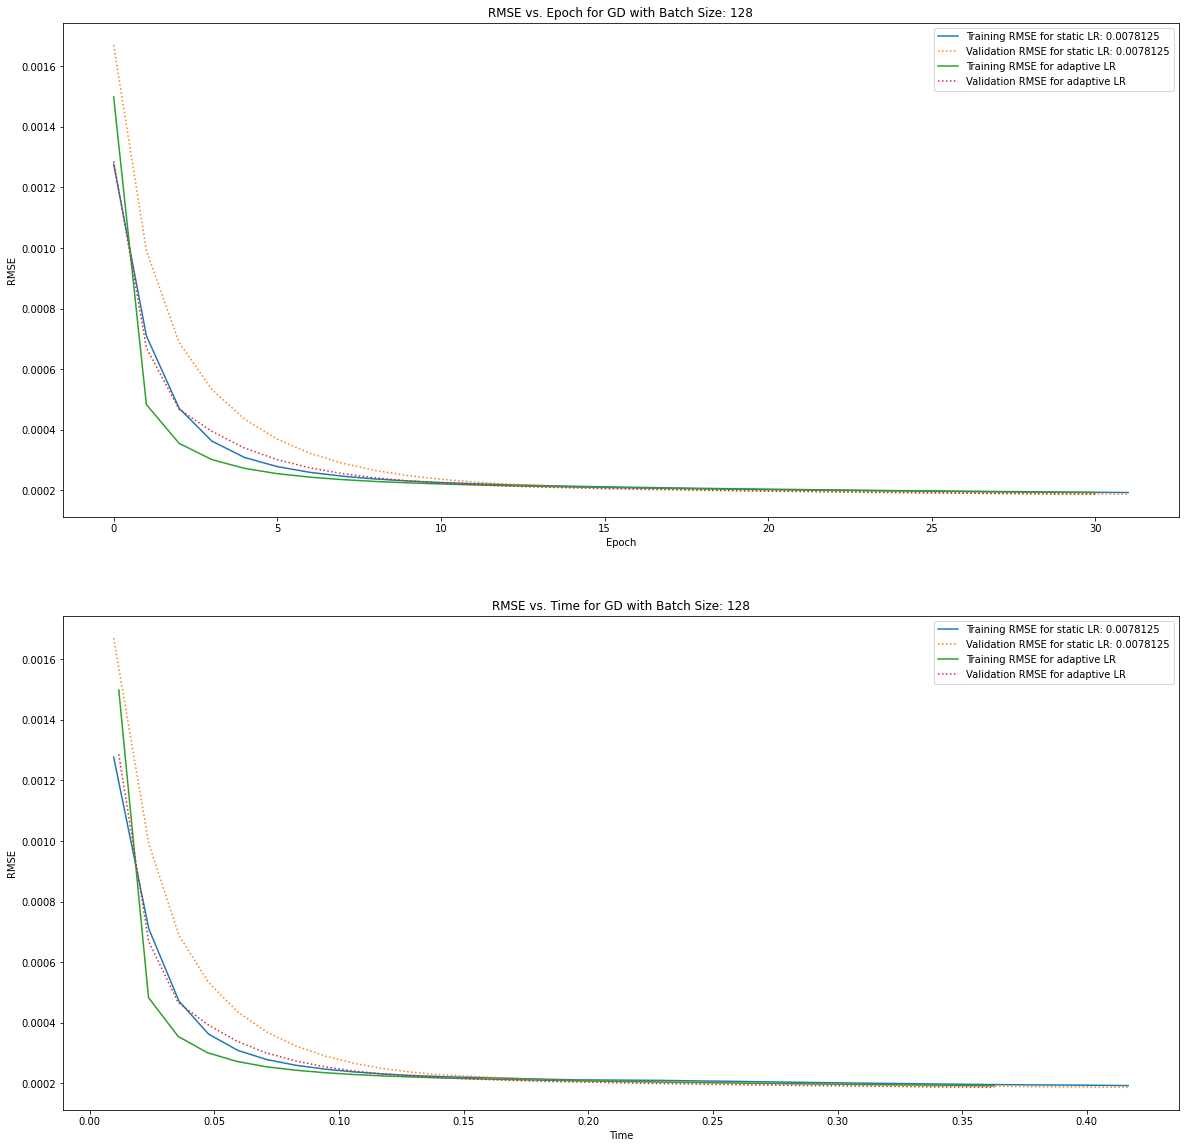

In [10]:
size = 128 # best batch size
LR = 0.0078125 # best static learning rate

fig, axs = plt.subplots(2, figsize=(20,20))
axs[0].set(xlabel = 'Epoch', ylabel = 'RMSE')
axs[0].set_title('RMSE vs. Epoch for GD with Batch Size: ' + str(size))
axs[1].set(xlabel = 'Time', ylabel = 'RMSE')
axs[1].set_title('RMSE vs. Time for GD with Batch Size: ' + str(size))

weights, train_rmse, valid_rmse, time_elapsed, convergence = mini_batch_gradient_descent (X_train_1, t_train, X_test_1, t_test, batch_size = size, lr = LR, CT = CT, max_it = 20000)
weights_new, train_rmse_new, valid_rmse_new, time_elapsed_new, convergence_new = mini_batch_gradient_descent_adaptive (X_train_1, t_train, X_test_1, t_test, batch_size = size, lr = LR, CT = CT, max_it = 20000)

axs[0].plot(train_rmse, '-', label = 'Training RMSE for static LR: ' + str(LR))
axs[0].plot(valid_rmse, ':', label = 'Validation RMSE for static LR: ' + str(LR))
axs[0].plot(train_rmse_new, '-', label = 'Training RMSE for adaptive LR')
axs[0].plot(valid_rmse_new, ':', label = 'Validation RMSE for adaptive LR')
axs[0].legend()
axs[1].plot(time_elapsed, train_rmse, '-', label = 'Training RMSE for static LR: ' + str(LR))
axs[1].plot(time_elapsed, valid_rmse, ':', label = 'Validation RMSE for static LR: ' + str(LR))
axs[1].plot(time_elapsed_new, train_rmse_new, '-', label = 'Training RMSE for adaptive LR')
axs[1].plot(time_elapsed_new, valid_rmse_new, ':', label = 'Validation RMSE for adaptive LR')
axs[1].legend()

plt.show()

## Part 7 - Gradient Descent with Additional Features and Regularization [3 marks]

Now, we'll apply linear regresssion to a toy dataset (`LR_data.csv`), with 10 features `x1`-`x10` and a "measurement" `y`. We'll take a few shortcuts by using built-in sklearn functions.

1. Data Preparation **[0.5]**
  * Print the dataset, and create Numpy arrays with inputs (X) and outputs (y). 
  * Split the dataset into training and validation sets (80% training, 20% validation). When splitting, set `random_state=1`.

2. Linear Regression **[0.5]**
  * Standardize the data using StandardScaler from sklearn.
  * Use the `sklearn.linear_model.LinearRegression` function [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to perform linear regression.
  * Print the RMSE for training and validation data.

3. Linear Regression with Additional Features **[0.5]**
  * Let's add more features to our dataset (up to degree 8) using `sklearn.preprocessing.PolynomialFeatures` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html). You'll want to create the additional features first, then perform standardization (start from non-standardized data).
  * Again, use `sklearn.linear_model.LinearRegression` to perform linear regression.
  * Print the RMSE for training and validation data.

4. Linear Regression with Additional Features and Regularization **[0.5]**
  * Let's switch models, and instead use the `sklearn.linear_model.Ridge` function [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) to perform linear regression with regularization. Apply the model to the processed data (additional, standardized) you used in 3 above. Use a `FOR` loop to run `sklearn.linear_model.Ridge` with different `alpha` values. Specifically, sweep `alpha` from 1E-2 to 1E10 (each step is an order of magnitude jump).

5. Discuss your results. What do you conclude? **[1]**

By looking at the graph "sklearn Function Performance Comparison", we can see that the plain Linear Regression method has a bad performance in predicting this dataset because it has large training and validation error. To improve this, we test the same method on dataset with additional features. The result shows the training error is decreased significantly while validation error is still high. This means with additional features added, the model becomes overfitting. It pays more attention to the noise of the data and memorize everything without generalization. To preventing overfitting, using ridge method adds a certain degrees of regularizer (a penalty to weights). With an appropriate regularization parameter, the model is more generalized and shows a much lower validation error. However, the resulting validation error is still very high after using all the methods, it illustrates that there is not a well-described regression model for this dataset.

In [11]:
import pandas as pd
df=pd.read_csv("https://www.eecg.utoronto.ca/~hadizade/APS1070/LR_data.csv" , skipinitialspace=True)

In [12]:
# create dataframe
data_raw = pd.DataFrame(df.values, index=df.index, columns=df.columns)
# print dataframe
print(data_raw)

X = np.array(data_raw.drop('y', axis = 1)) # Inputs
y = np.array(data_raw['y']) # Outputs

# split dataset (8:2)
X_train, X_test, t_train, t_test = train_test_split(X, y, test_size=0.2, random_state=1)

           x1        x2        x3  ...        x9       x10             y
0    1.454481  4.940543  7.116015  ...  3.841250  6.121133  6.575066e+06
1    4.907182  1.653654  7.339445  ...  8.646473  3.806860  8.419881e+06
2    1.842804  1.183878  4.203206  ...  3.260723  5.463808  9.745537e+04
3    2.393457  0.094127  3.208929  ...  7.312995  5.475240  1.129200e+04
4    5.093724  3.905293  4.858562  ...  9.128607  0.790795  3.105448e+05
..        ...       ...       ...  ...       ...       ...           ...
195  2.936450  2.094812  9.493814  ...  7.622569  3.037162  6.599726e+07
196  4.915597  1.953974  7.312552  ...  7.043560  5.745565  8.176250e+06
197  6.772096  6.406489  4.638352  ...  9.386478  4.147710  2.144147e+05
198  3.940339  4.330498  6.693371  ...  7.883720  8.525164  4.028735e+06
199  8.636129  1.272939  4.339175  ...  9.543772  5.673870  1.257168e+05

[200 rows x 11 columns]


In [13]:
# standardize dataset (only feature data)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train_std, t_train)

y_train = reg.predict(X_train_std) # training sets
y_test = reg.predict(X_test_std) # validation sets

print('Perform Linear Regression: ')
print('RMSE for training sets: ', rmse(y_train, t_train))
print('RMSE for validation sets: ', rmse(y_test, t_test))

Perform Linear Regression: 
RMSE for training sets:  16296980.655667372
RMSE for validation sets:  14061578.864980105


In [14]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(8)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

# standardize dataset (only feature data)
scaler_poly = StandardScaler()
scaler_poly.fit(X_train_poly)
X_train_poly_std = scaler_poly.transform(X_train_poly)
X_test_poly_std = scaler_poly.transform(X_test_poly)

reg_poly = LinearRegression().fit(X_train_poly_std, t_train)

y_train_poly = reg_poly.predict(X_train_poly_std) # training sets
y_test_poly = reg_poly.predict(X_test_poly_std) # validation sets

print('Perform Linear Regression with Additional Features: ')
print('RMSE for training sets: ', rmse(y_train_poly, t_train))
print('RMSE for validation sets: ', rmse(y_test_poly, t_test))

Perform Linear Regression with Additional Features: 
RMSE for training sets:  1.1154878119198678e-07
RMSE for validation sets:  10920908.905406754


Perform Linear Regression with Additional Features and Regularization: 


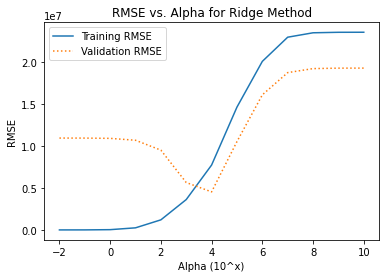

In [15]:
from sklearn.linear_model import Ridge
alpha_list = []
rmse_list_train = []
rmse_list_test = []

for i in range (13):
  clf = Ridge(alpha=10**(-2+i))
  clf.fit(X_train_poly_std, t_train)
  y_train_ridge = clf.predict(X_train_poly_std) # training sets
  y_test_ridge = clf.predict(X_test_poly_std) # validation sets

  alpha_list.append(-2+i)
  rmse_list_train.append(rmse(y_train_ridge, t_train))
  rmse_list_test.append(rmse(y_test_ridge, t_test))

plt.xlabel('Alpha (10^x)')
plt.ylabel('RMSE')
plt.title('RMSE vs. Alpha for Ridge Method')
plt.plot(alpha_list, rmse_list_train, '-', label = 'Training RMSE')
plt.plot(alpha_list, rmse_list_test, ':', label = 'Validation RMSE')
plt.legend()
print('Perform Linear Regression with Additional Features and Regularization: ')
plt.show()

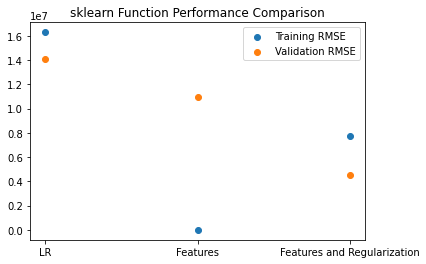

In [16]:
index = rmse_list_test.index(min(rmse_list_test)) # best regularizer parameter in the above method
RMSE_TRAIN = [rmse(y_train, t_train), rmse(y_train_poly, t_train), rmse_list_train[index]]
RMSE_TEST= [rmse(y_test, t_test), rmse(y_test_poly, t_test), rmse_list_test[index]]
plt.scatter(['LR','Features','Features and Regularization'], RMSE_TRAIN, label = 'Training RMSE')
plt.scatter(['LR','Features','Features and Regularization'], RMSE_TEST, label = 'Validation RMSE')
plt.legend()
plt.title('sklearn Function Performance Comparison')
plt.show()

## Part 8 - Linear Regression with a Custom Dataset [2 marks]


Find a dataset online and train and validate a linear regression model with the techniques you learned in this Project.

*   Introduce your dataset.**[0.5]**

This is a preprocessed dataset found on kaggle. It has no missing values so it is easy to directly implement our regression model without additional data cleanup. 
 The columns X1-X6 describe numerical features of the real estate. The column Y shows the real estate price.

*   Explain your approach. **[0.5]**

Our goal is to predict the price of the real estate based on the feature values.

To achieve this, we first split dataset into training and validation data. 

Then, standardize feature data using StandardScaler. 

Then, we add a column of 1 as a constant(inteception) for the feature data. 

Then, since dataset is small, we can implement direct solution to solve the problem at low computation cost. 

Finally, we compute RMSE for training and validation datasets to check the model performance. 

*   Summarize your results. **[1]**

By using the direct solution method, we obtained RMSE for training sets is 9.24686364310676. RMSE for validation sets is 6.708987046879438. This shows validation data fits even better than the training data to our regression model. The weights for the model is [38.71299094  1.60806629 -2.85420187 -6.0894846   3.14445391  2.8041558
 -0.53983317] for [1 X1 X2 X3 X4 X5 X6]

Hint: you can find various datasets in here: https://www.kaggle.com/datasets.

To use a dataset in Colab, you can upload it in your Google drive and access it in Colab ([help here](https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a)), or you can download the dataset on your local machine and upload it directly to Colab using the following script.

```
from google.colab import files
uploaded = files.upload()
```

When submitting your project on Quercus, Please make sure you are also uploading your dataset so we can fully run your notebook.






In [17]:
from google.colab import files
uploaded = files.upload()

Saving real_estate.csv to real_estate.csv


In [18]:
df=pd.read_csv('real_estate.csv')
# create dataframe
estate_raw = pd.DataFrame(df.values, index=df.index, columns=df.columns)
# print dataframe
print(estate_raw)

feature_raw = estate_raw.drop(['No','Y house price of unit area'], axis = 1)
target_raw = estate_raw['Y house price of unit area']

print('Features: ', feature_raw.columns)
print('First few targets: ', target_raw.head())

        No  X1 transaction date  ...  X6 longitude  Y house price of unit area
0      1.0             2012.917  ...     121.54024                        37.9
1      2.0             2012.917  ...     121.53951                        42.2
2      3.0             2013.583  ...     121.54391                        47.3
3      4.0             2013.500  ...     121.54391                        54.8
4      5.0             2012.833  ...     121.54245                        43.1
..     ...                  ...  ...           ...                         ...
409  410.0             2013.000  ...     121.50381                        15.4
410  411.0             2012.667  ...     121.54310                        50.0
411  412.0             2013.250  ...     121.53986                        40.6
412  413.0             2013.000  ...     121.54067                        52.5
413  414.0             2013.500  ...     121.54310                        63.9

[414 rows x 8 columns]
Features:  Index(['X1 transa

In [19]:
# split dataset (8:2)
X_train, X_test, t_train, t_test = train_test_split(feature_raw, target_raw, test_size=0.2, random_state=1)

# standardize dataset (only feature data)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

# insert a column of 1
X_train_1 = np.hstack((np.ones((X_train_std.shape[0],1)), X_train_std)) # training sets
X_test_1 = np.hstack((np.ones((X_test_std.shape[0],1)), X_test_std)) # validation sets

In [20]:
# direct solution method
W = np.dot(inv(np.dot(X_train_1.T, X_train_1)), np.dot(X_train_1.T, t_train))

# prediction
yPred_train = np.dot(X_train_1, W) # training sets
yPred_test = np.dot(X_test_1, W) # validation sets

# report RMSE
print('RMSE for training sets: ', rmse(yPred_train, t_train))
print('RMSE for validation sets: ', rmse(yPred_test, t_test))
print('Weights: ', W)

RMSE for training sets:  9.24686364310676
RMSE for validation sets:  6.708987046879438
Weights:  [38.71299094  1.60806629 -2.85420187 -6.0894846   3.14445391  2.8041558
 -0.53983317]
